In [37]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [38]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
#OptimalXAI = np.load("OptimalXAIFeature.npy")
# now something different
OptimalXAI = np.load("XAI_modes.npy")
OptimalXAI

array([[ 0, 47],
       [ 1, 37],
       [ 2,  8],
       [ 3, 43],
       [ 4, 45],
       [ 5, 43],
       [ 6,  8],
       [ 7,  8]])

In [39]:
clf = RandomForestClassifier(max_depth=20, random_state=0)

In [40]:
# 1 vs. all other clusters
print(OptimalXAI[0,:])

Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
print(Label0)

Data_0opt = CorrMatrices[:,OptimalXAI[0,1]]
Data_0opt = Data_0opt.reshape(-1,1)

# transform the imbalanced Data set
oversample = SMOTE()
Data_0opt, Label0 = oversample.fit_resample(Data_0opt, Label0)

X_train, X_test, y_train, y_test = train_test_split(Data_0opt, Label0,
                                                    test_size=0.5, random_state=1)
#X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.mean(), X_test.mean(), y_train.mean(), y_test.mean())

[ 0 47]
[1 1 0 ... 0 0 0]
0.3735827286481072 0.3798143209780204 0.5062355658198614 0.49376443418013855


In [41]:
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(np.mean(y_hat))
np.mean(y_hat == y_test )

0.5378752886836028


0.7392609699769053

Optimal feature is 47


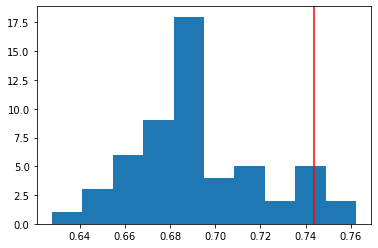

Optimal feature is 37


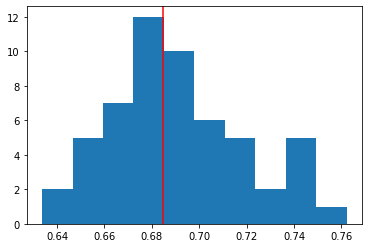

Optimal feature is 8


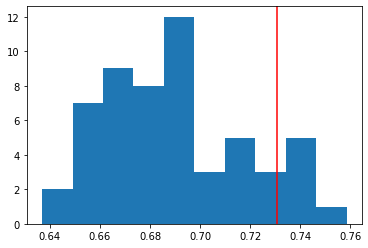

Optimal feature is 43


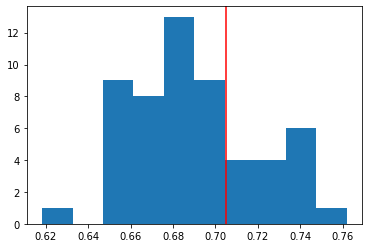

Optimal feature is 45


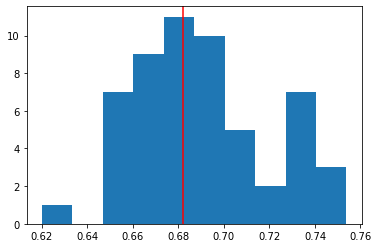

Optimal feature is 43


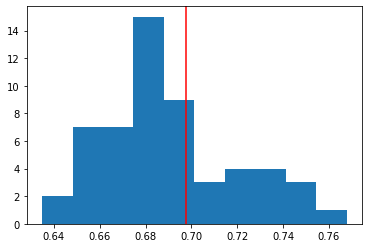

Optimal feature is 8


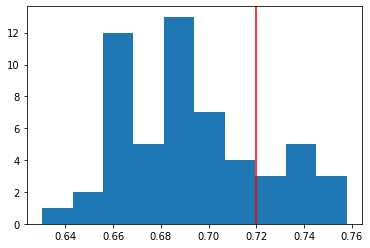

Optimal feature is 8


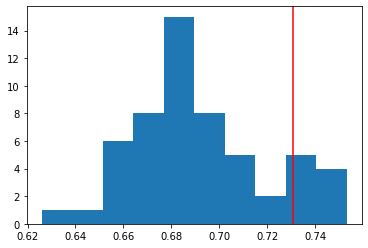

In [42]:
oversample = SMOTE()
for j in range(OptimalXAI.shape[0]):
    Scores = list()
    print("Optimal feature is", OptimalXAI[j,1])
    for i in range(CorrMatrices.shape[1]):
        Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
        Data_0 = CorrMatrices[:,i].reshape(-1,1)
        Data_0, Label0 = oversample.fit_resample(Data_0, Label0)
        X_train, X_test, y_train, y_test = train_test_split(Data_0, Label0,
                                                    test_size=0.5, random_state=1)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        Scores.append( np.mean(y_hat == y_test ))
    plt.hist(Scores)
    plt.axvline(Scores[OptimalXAI[j,1]],c="red")
    plt.show()

### Train NN with all relevant features

For this, we need one-hot encoded y

In [43]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{37, 8, 43, 45, 47}
(5251, 5)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


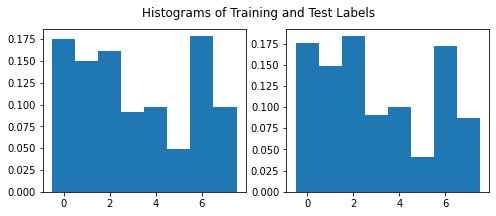

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [45]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

5 8
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               1536      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 1024)              132096    
                                                                 
 dense_16 (Dense)            (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 8)            

In [46]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 1s 18ms/step - loss: 2.0597 - accuracy: 0.1632 - val_loss: 2.0299 - val_accuracy: 0.1717
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 2.0039 - accuracy: 0.1865 - val_loss: 1.9742 - val_accuracy: 0.1717
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 1.9485 - accuracy: 0.1853 - val_loss: 1.9150 - val_accuracy: 0.1717
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 1.8934 - accuracy: 0.1910 - val_loss: 1.8457 - val_accuracy: 0.1848
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 1.8047 - accuracy: 0.2462 - val_loss: 1.7544 - val_accuracy: 0.2843
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 1.7085 - accuracy: 0.3536 - val_loss: 1.6409 - val_accuracy: 0.3667
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 1.5899 - accuracy: 0.3974 - val_loss: 1.5090 - val_accuracy: 0.4247
Epoch 8/100

In [47]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.7899596076168494


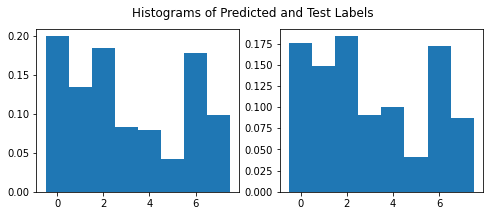

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Now with some other features

In [49]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [50]:
TestNN(54321)

0.7259088286208887

In [51]:
TestNN()

0.7212925562608193

In [52]:
Runs = 100
NN_comparison = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    print(i,s,Test_Score)
    NN_comparison[i] = Test_Score


0 [5206] 0.638199653779573
1 [8676] 0.6612810155799193
2 [2446] 0.7847663012117715
3 [2594] 0.6947489901904212
4 [0] 0.6191575302942873
5 [7221] 0.7293710328909405
6 [6887] 0.777264858626659
7 [7580] 0.7316791690709752
8 [30] 0.6220427005193306
9 [7699] 0.6618580496249279
10 [4222] 0.825735718407386
11 [6242] 0.7714945181765724
12 [1070] 0.7391806116560877
13 [6397] 0.8055395268320831
14 [7177] 0.6785920369301789
15 [2956] 0.7455279861511829
16 [395] 0.7524523946912868
17 [5141] 0.710328909405655
18 [8748] 0.6699365262550491
19 [6897] 0.7732256203115984
20 [5977] 0.6751298326601269
21 [5705] 0.7668782458165032
22 [4016] 0.6814772071552222
23 [2914] 0.7305251009809579
24 [142] 0.7991921523369879
25 [657] 0.8020773225620311
26 [9479] 0.8470859780727062
27 [4210] 0.7195614541257934
28 [8513] 0.7178303519907675
29 [9173] 0.7778418926716676
30 [9637] 0.7547605308713214
31 [6801] 0.842469705712637
32 [3333] 0.7928447778418927
33 [921] 0.6462781304096942
34 [1677] 0.6739757645701097
35 [5278]

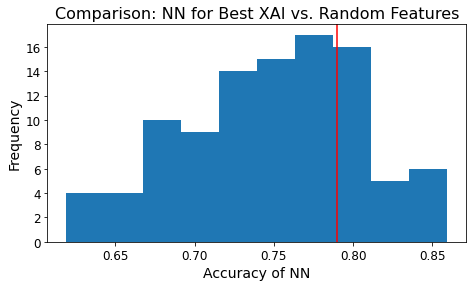

In [53]:
fig = plt.gcf()
fig.set_size_inches(7.5,4)
plt.hist(NN_comparison)
plt.axvline(Accuracy_BestXAI,
            c="red")
plt.xlabel("Accuracy of NN",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.title("Comparison: NN for Best XAI vs. Random Features",
          fontsize = 16)
plt.savefig("Comparison_RandomFeatures_vs_XAImode_100NN",dpi=600)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [54]:
np.median(NN_comparison),np.mean(NN_comparison), Accuracy_BestXAI

(0.7530294287362954, 0.7482342758222735, 0.7899596076168494)